In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from scipy.io import wavfile
from pydub import AudioSegment, effects
from pydub.silence import split_on_silence

In [2]:
#GraphicMaker
#reads a wav file and plots it
class GraphAudio():
  def readFile(self,path):
    #reads wav file
    self.samplerate, self.data = wavfile.read(path)
    print("new file read: "+path)
    self.times = np.arange(len(self.data))/float(self.samplerate)


  def graph(self):
        plt.figure(figsize=(30, 4))
       # Check if the audio data is mono or stereo
        if self.data.ndim == 1:
            plt.plot(self.times, self.data, color='k')  # Plot for mono audio
        else:
            plt.fill_between(self.times, self.data[:,0], self.data[:,1], color='k')  # Plot for stereo audio
        plt.xlim(self.times[0], self.times[-1])
        plt.xlabel('time (s)')
        plt.show()

In [3]:
# Audio Splitter
# splits a wav file into chunks of audio separated by silence
class SplitWavAudioMubin():
    def __init__(self, folder, folder_export_path, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '/' + filename + ".wav"
        self.folder_export_path = folder_export_path
        print(self.filepath)
        self.audio = AudioSegment.from_wav(self.filepath)

        self.new_metadata=[]

    def get_duration(self):
        return self.audio.duration_seconds

    def split(self, min_len, thresh):
        #splits the audio file
        print("audio to predict: "+self.filepath)
        print("dbfs: "+str(self.audio.dBFS))
        reduced_noise = self.audio.low_pass_filter(5000).high_pass_filter(200)
        audio_normal=reduced_noise.normalize(-20.0)        #normalize audio
        #split
        chunks = split_on_silence(
          #audio to process
          self.audio,
          #min silence in ms - 1000ms equals 1s
          min_silence_len = min_len, #200 default
          silence_thresh = self.audio.dBFS-thresh, #16 default
          keep_silence = 200, # optional
          )
        print("Number of chunks detected:", len(chunks))
        #export audio
        print("export path:"+self.folder_export_path + '/' + self.filename+"_")
        for i, chunk in enumerate(chunks):
          chunk.export(self.folder_export_path + '/' + self.filename+"_"+str(i)+".wav", format="wav")
          self.new_metadata.append([self.filename,i])
          print("appended chunk "+str(i))
        print("split successfully for: "+self.filename+" with "+ str(len(chunks)) + " samples")

Dataset-for-Binary/audio_0.wav
audio to predict: Dataset-for-Binary/audio_0.wav
dbfs: -22.550533374329774
Number of chunks detected: 25
export path:Dataset-for-Binary/Split-audio/0/audio_0_
appended chunk 0
appended chunk 1
appended chunk 2
appended chunk 3
appended chunk 4
appended chunk 5
appended chunk 6
appended chunk 7
appended chunk 8
appended chunk 9
appended chunk 10
appended chunk 11
appended chunk 12
appended chunk 13
appended chunk 14
appended chunk 15
appended chunk 16
appended chunk 17
appended chunk 18
appended chunk 19
appended chunk 20
appended chunk 21
appended chunk 22
appended chunk 23
appended chunk 24
split successfully for: audio_0 with 25 samples
Dataset-for-Binary/audio_1.wav
audio to predict: Dataset-for-Binary/audio_1.wav
dbfs: -27.038053578874546
Number of chunks detected: 25
export path:Dataset-for-Binary/Split-audio/1/audio_1_
appended chunk 0
appended chunk 1
appended chunk 2
appended chunk 3
appended chunk 4
appended chunk 5
appended chunk 6
appended chun

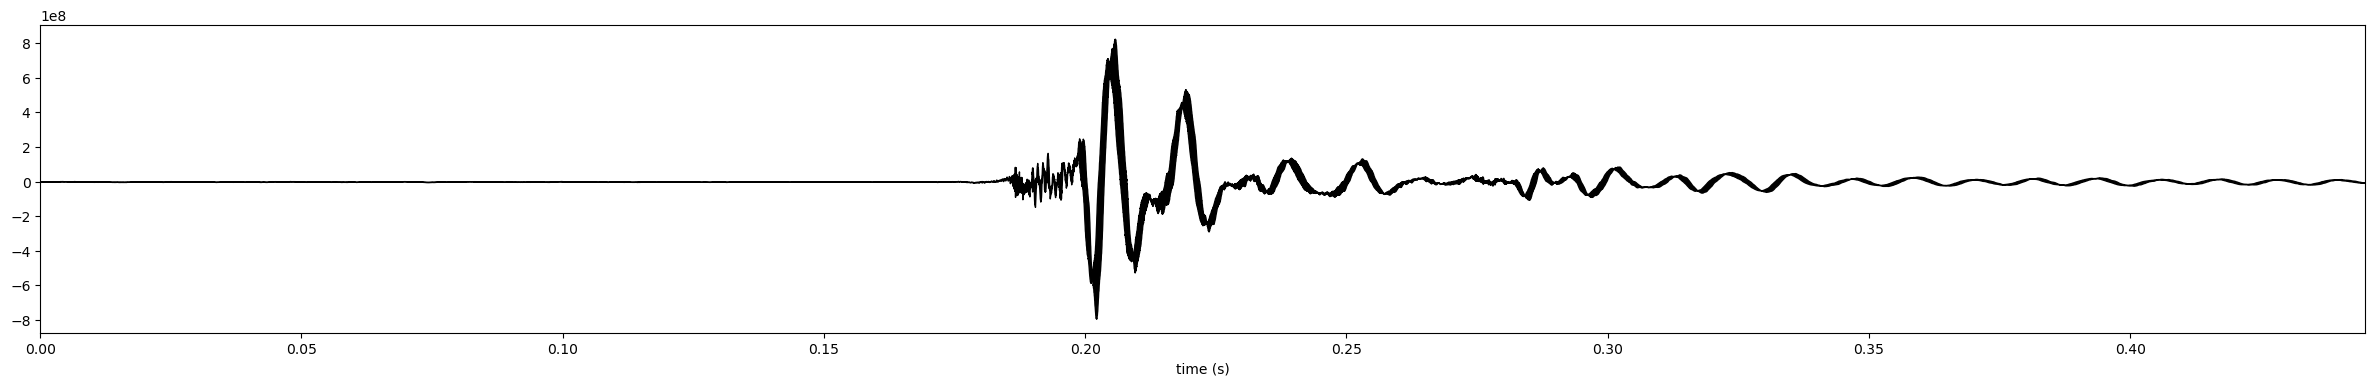

In [5]:
#para 0
split_wav = SplitWavAudioMubin('Dataset-for-Binary', 'Dataset-for-Binary/Split-audio/0', 'audio_0')
split_wav.split(min_len=200,thresh=10)

#para 1
split_wav = SplitWavAudioMubin('Dataset-for-Binary', 'Dataset-for-Binary/Split-audio/1', 'audio_1')
split_wav.split(min_len=200,thresh=10)

#we graph the first chunk of the audio to check if it was split correctly
graphicMaker=GraphAudio()
graphicMaker.readFile('Dataset-for-Binary/Split-audio/1/audio_1_0.wav')
graphicMaker.graph()

In [6]:
# Preprocessing

# Set the path to dataset folder
data_dir = 'Dataset-for-Binary/Split-audio'

# Load and preprocess audio data using spectrograms
#Label corresponds to folder names in Split-audio
labels = os.listdir(data_dir)
audio_data = []
target_labels = []

for label in labels:
	label_dir = data_dir + '/' + label
	# Iterate through each audio file in the respective folder
	for audio_file in os.listdir(label_dir):
		audio_path = os.path.join(label_dir, audio_file)
		y, sr = librosa.load(audio_path, duration=3) # Load audio and limit to 3 seconds
		spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
		spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
		# Transpose the spectrogram to have the shape (timesteps, n_mels)
		spectrogram = spectrogram.T
		audio_data.append(spectrogram)
		target_labels.append(label)

In [7]:
# Encode target labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(target_labels)
 
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_data, encoded_labels, test_size=0.2, random_state=42)
 
# Ensure all spectrograms have the same shape
max_length = max([spec.shape[0] for spec in audio_data])
X_train = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in X_train]
X_test = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in X_test]
 
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

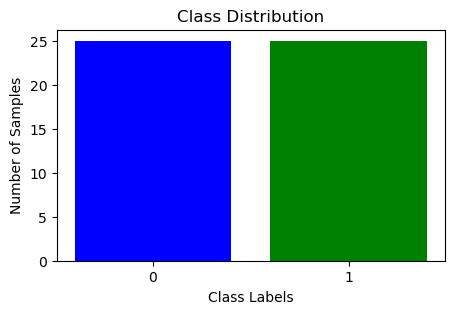

In [8]:
# Count the number of samples in each class
class_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in labels]
# Define colors for each class
class_colors = ['blue', 'green']
# Create a bar chart to visualize class distribution
plt.figure(figsize=(5, 3))
plt.bar(labels, class_counts, color=class_colors)
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

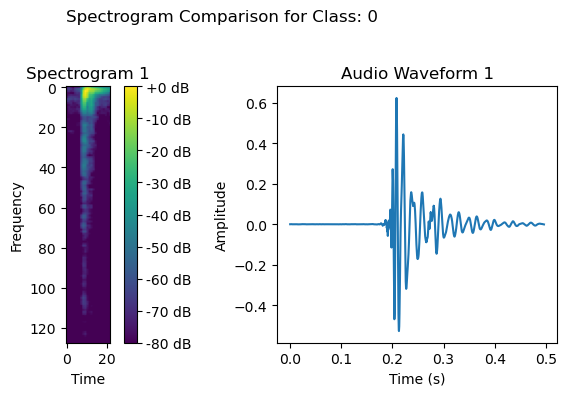

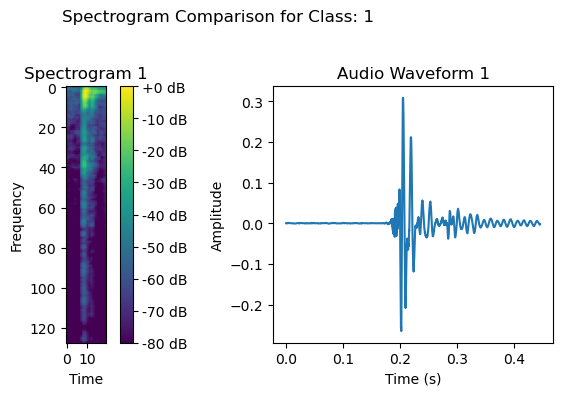

In [9]:
# Define a function to plot spectrograms for a class
def plot_spectrograms(label, num_samples=3):
    label_dir = os.path.join(data_dir, label)
    plt.figure(figsize=(7, 4))
    plt.suptitle(f"Spectrogram Comparison for Class: {label}")
 
    for i, audio_file in enumerate(os.listdir(label_dir)[:num_samples]):
        audio_path = os.path.join(label_dir, audio_file)
        y, sr = librosa.load(audio_path, duration=3)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
 
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title(f"Spectrogram {i + 1}")
        plt.imshow(spectrogram, cmap="viridis")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
 
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title(f"Audio Waveform {i + 1}")
        plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
 
 
# Visualize spectrograms and audio waveforms for "0" class
# adjust num_samples parameter to see desired number of  visualization of samples
plot_spectrograms("0", num_samples=1)
print('\n')
# Visualize spectrograms and audio waveforms for "1" class
plot_spectrograms("1", num_samples=1)

In [10]:
# Convert the data to a flat 2D shape
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create Gradient Boosting classifier
model = GradientBoostingClassifier(random_state=42)
# Train the model
model.fit(X_train_flat, y_train)

# Make predictions
y_pred = model.predict(X_test_flat)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.4f}".format(accuracy))
print("F1 score: {:.4f}".format(f1))


Accuracy: 1.0000
F1 score: 1.0000
